In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
mp_key = "KcpGNlNwBWUwWN6pcJS1SzDUsDUsCA2z"
mp_id = "mp-2286"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Variables utiles pour le problème
temperatures = np.arange(0,1000,5)
R = 8.314
nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*nat*R)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy.integrate as integrate

In [6]:
# Définition du modèle de Debye
def debye_model(T, theta_D):
    return (3 * (T / theta_D)**3) * integrate.quad(lambda x: (x**4 * np.exp(x)) / (np.exp(x) - 1)**2, 0, theta_D / T)[0]

# Définition du modèle d'Einstein
def einstein_model(T, theta_E):
    return ((theta_E / T)**2 * np.exp(theta_E / T)) / (np.exp(theta_E / T) - 1)**2

In [7]:
# Calcul de la température de Debye
err_min = 0
Td = 0 
for i in range(1,1000):  
    err = 0
    for j in range(1,len(temperatures)):
        err += (debye_model(temperatures[j], i) - ph_cv[j])**2
    if i == 1:
        err_min = err
    if err < err_min:
        err_min = err
        Td = i
print("Température de Debye :", Td,"K")

cv_debye = [0]
for k in range(1,len(temperatures)):
    cv_debye.append(debye_model(temperatures[k], Td))

Température de Debye : 472 K


In [8]:
# Calcul de la température d'Einstein
err_min = 0
Te = 0 
for i in range(1,1000):  
    err = 0
    for j in range(1,len(temperatures)):
        err += (einstein_model(temperatures[j], i) - ph_cv[j])**2
    if i == 1:
        err_min = err
    if err < err_min:
        err_min = err
        Te = i
print("Température d'Einstein :", Te,"K")

cv_einstein = [0] 
for k in range(1,len(temperatures)):
    cv_einstein.append(einstein_model(temperatures[k], Te))

Température d'Einstein : 349 K


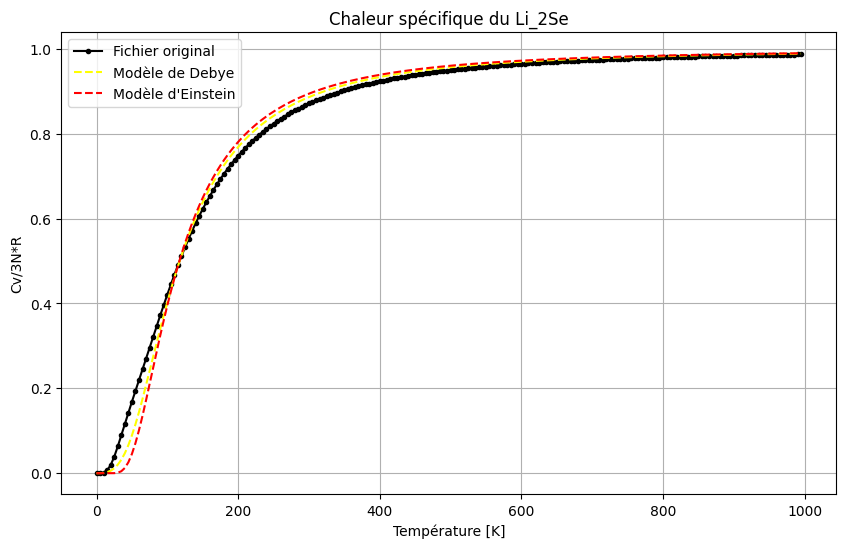

In [9]:
# Création du graphe
plt.figure(figsize=(10, 6))
plt.plot(temperatures, ph_cv, marker='o', linestyle='-', color='black', markersize=3, label='Fichier original')

# Courbes des modèles optimisés
plt.plot(temperatures, cv_debye, linestyle='--', color='yellow', label='Modèle de Debye')
plt.plot(temperatures, cv_einstein, linestyle='--', color='red', label='Modèle d\'Einstein')

plt.title('Chaleur spécifique du Li_2Se')
plt.xlabel('Température [K]')
plt.ylabel('Cv/3N*R')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
hb = 6.626*10**(-34)/(2*np.pi) 
kb = 1.380649*10**(-23) 
A = 3*nat
frequency = ph_dos.frequencies
density = ph_dos.densities

In [11]:
# Debye: 
w_d = 10**(-12)*kb*Td/(hb) 
dos_d = []
v = 95.90*10**(-30) 

# Einstein: delta de dirac 
w_e = 10**(-12)*kb*Te/(hb)  
f_e = w_e/(2*np.pi) 

q_d = (6*np.pi**2/v)**(1/3) 

for i in range(len(frequency)) : 
    w = frequency[i]*2*np.pi 
    if(w < w_d) : 
        dos_d.append(2*np.pi*3*nat*v*w**2*q_d**3/(2*np.pi**2*(w_d)**3))
    else : 
        dos_d.append(0)

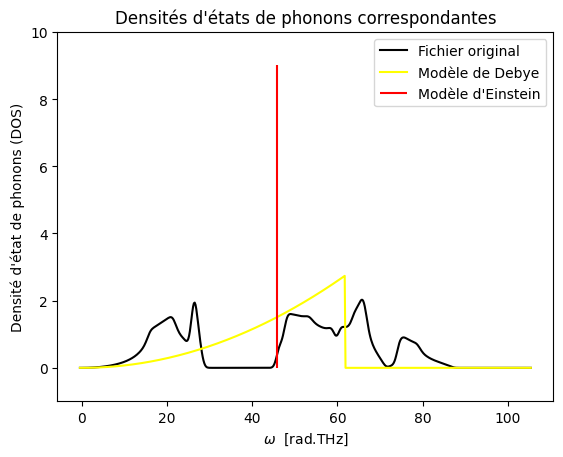

In [12]:
plt.plot(frequency*2*np.pi, density, color='black', label = "Fichier original")
plt.plot(frequency*2*np.pi, dos_d, color='yellow', label = "Modèle de Debye")
plt.vlines(f_e*2*np.pi, 0, A, label = "Modèle d'Einstein", color = 'red')
plt.xlabel('$\omega$  [rad.THz]')
plt.ylabel("Densité d'état de phonons (DOS)")
plt.ylim(-1, 10)
plt.title("Densités d'états de phonons correspondantes")
plt.legend()
plt.show()